# В этом семинаре разберемся: 
+ как подготавливать данные  
+ как составлять нейросети 
+ как работает автоградиент
+ как собственно тренировать нейросети в PyTorch (наконец-то)

# 1. Готовим данные

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Lambda
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

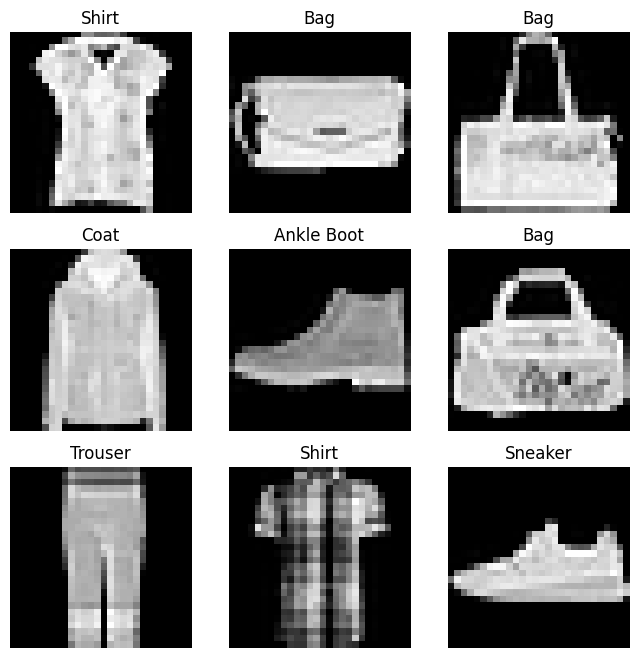

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Создаем собственный датакласс

In [136]:
import pandas as pd


class CustomImageDataset(Dataset):
    def __init__(self, data_file, transform=None, target_transform=None):
        self.data = pd.read_csv(data_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.reshape(28, 28).astype(np.uint8)
        label = self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [145]:
train = CustomImageDataset('../data/fashion-mnist_train.csv', 
                           transform=ToTensor(), 
                           target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test = CustomImageDataset('../data/fashion-mnist_test.csv', 
                          transform=ToTensor(),
                          target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

In [146]:
img, label = train[0]

## Подключаем даталоадеры

In [148]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

# 2. Собираем нейросеть

In [149]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [150]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [151]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [152]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([2])


## Детально посмотрим в слои сетки

In [156]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [157]:
input_image

tensor([[[0.4899, 0.1325, 0.7472,  ..., 0.0613, 0.3664, 0.5482],
         [0.4220, 0.9199, 0.2164,  ..., 0.4466, 0.9486, 0.3860],
         [0.9618, 0.8667, 0.0367,  ..., 0.6430, 0.4708, 0.0162],
         ...,
         [0.1544, 0.5153, 0.9647,  ..., 0.1009, 0.9354, 0.1673],
         [0.9798, 0.0051, 0.4079,  ..., 0.8435, 0.7452, 0.4487],
         [0.7943, 0.0472, 0.5549,  ..., 0.9201, 0.0786, 0.4221]],

        [[0.6306, 0.0148, 0.3979,  ..., 0.1825, 0.7369, 0.4908],
         [0.5922, 0.9511, 0.1664,  ..., 0.5267, 0.7232, 0.0020],
         [0.4703, 0.5678, 0.4833,  ..., 0.2756, 0.1583, 0.5245],
         ...,
         [0.2636, 0.8609, 0.7687,  ..., 0.0406, 0.1025, 0.0472],
         [0.7418, 0.4088, 0.0761,  ..., 0.3555, 0.1208, 0.1619],
         [0.8210, 0.6360, 0.6797,  ..., 0.3456, 0.3935, 0.5224]],

        [[0.0865, 0.1956, 0.5699,  ..., 0.2709, 0.3708, 0.2358],
         [0.5071, 0.2486, 0.2796,  ..., 0.9153, 0.0120, 0.5786],
         [0.9911, 0.4655, 0.4914,  ..., 0.2968, 0.2232, 0.

In [158]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [159]:
flat_image

tensor([[0.4899, 0.1325, 0.7472,  ..., 0.9201, 0.0786, 0.4221],
        [0.6306, 0.0148, 0.3979,  ..., 0.3456, 0.3935, 0.5224],
        [0.0865, 0.1956, 0.5699,  ..., 0.6757, 0.3394, 0.5679]])

In [160]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [161]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.3428, -0.0430, -0.1493,  0.3484, -0.2700, -0.0489,  0.2666, -0.0604,
         -0.2784, -0.0864,  0.0292, -0.1979,  0.4662, -0.3499, -0.3847, -0.0644,
          0.2661,  0.2009,  0.1346,  0.5266],
        [-0.4561,  0.3107, -0.3108, -0.1001, -0.0282, -0.3255,  0.2509,  0.2342,
         -0.0371,  0.0619,  0.1581, -0.3409,  0.2191, -0.4821, -0.3128,  0.1714,
         -0.1419,  0.1604,  0.1752,  0.6458],
        [-0.3798,  0.3733, -0.4321,  0.2387, -0.6847,  0.2120,  0.1272,  0.3305,
         -0.2808,  0.0096,  0.1621, -0.3004,  0.1045, -0.4295, -0.3311, -0.0251,
          0.4909,  0.3837,  0.4319,  0.4801]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0000, 0.3484, 0.0000, 0.0000, 0.2666, 0.0000, 0.0000,
         0.0000, 0.0292, 0.0000, 0.4662, 0.0000, 0.0000, 0.0000, 0.2661, 0.2009,
         0.1346, 0.5266],
        [0.0000, 0.3107, 0.0000, 0.0000, 0.0000, 0.0000, 0.2509, 0.2342, 0.0000,
         0.0619, 0.1581, 0.0000, 0.2191, 0.0000, 0.00

In [162]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

In [166]:
logits.shape

torch.Size([3, 10])

In [174]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [179]:
pred_probab.argmax(dim=1)

tensor([8, 8, 8])

In [164]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0092, -0.0204, -0.0137,  ..., -0.0217, -0.0240, -0.0293],
        [ 0.0178,  0.0230, -0.0292,  ..., -0.0199, -0.0044,  0.0191]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0111, -0.0285], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0177, -0.0013, -0.0197,  ...,  0.0225,  0.0172, -0.0346],
        [-0.0028, -0.0209, -0.0207,  ..., -0.0016, -0.0355,  0.0423]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

# 3. Смотрим автоградиент

![](https://pytorch.org/tutorials/_images/comp-graph.png "граф вычислений")

In [181]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [182]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x000001E0449453D0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001E041175EB0>


In [183]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0995, 0.2591, 0.2448],
        [0.0995, 0.2591, 0.2448],
        [0.0995, 0.2591, 0.2448],
        [0.0995, 0.2591, 0.2448],
        [0.0995, 0.2591, 0.2448]])
tensor([0.0995, 0.2591, 0.2448])


In [184]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [185]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


In [186]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


# 4. Тренировка нейросети

#### Инициализируем модель

In [187]:
model = NeuralNetwork() 

#### Инициализируем параметры

In [188]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

#### Инициализируем функцию потерь

In [189]:
loss_fn = nn.CrossEntropyLoss()

#### Инициализируем оптимизатор

In [190]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Описываем функции тренировки и тестирования модели

In [205]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [206]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.171762  [    0/60000]
loss: 2.133280  [ 6400/60000]
loss: 2.116912  [12800/60000]
loss: 2.094823  [19200/60000]
loss: 2.079936  [25600/60000]
loss: 2.046705  [32000/60000]
loss: 1.982390  [38400/60000]
loss: 1.968118  [44800/60000]
loss: 1.934288  [51200/60000]
loss: 1.902326  [57600/60000]
Test Error: 
 Accuracy: 53.2%, Avg loss: 1.885390 

Epoch 2
-------------------------------
loss: 1.882400  [    0/60000]
loss: 1.847594  [ 6400/60000]
loss: 1.740669  [12800/60000]
loss: 1.799914  [19200/60000]
loss: 1.769427  [25600/60000]
loss: 1.687383  [32000/60000]
loss: 1.653622  [38400/60000]
loss: 1.639971  [44800/60000]
loss: 1.549834  [51200/60000]
loss: 1.574642  [57600/60000]
Test Error: 
 Accuracy: 59.1%, Avg loss: 1.524644 

Epoch 3
-------------------------------
loss: 1.453294  [    0/60000]
loss: 1.429314  [ 6400/60000]
loss: 1.443410  [12800/60000]
loss: 1.354199  [19200/60000]
loss: 1.379937  [25600/60000]
loss: 1.305567  [32000/600